# NCAA Embeddings
> Learning complex features of NCAA teams with limited data.

- toc: true 
- badges: true
- comments: true
- categories: [python, jupyter, sports, basketball, Kaggle, Coursera]

## Intro

One of my big projects this past year was preparing to my first Kaggle competition - both the NCAA [Men's](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament) and [Women's](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament) basketball tournaments! Unfortunately, the NCAA tournament was cancelled due to the Covid-19 pandemic. Regardless, working through my different ideas was a great way to learn some of the basics and nuances of training an ML model effectively.

I tried a few different types of models including a simple 2 layer neural net using [FastAI](https://docs.fast.ai/) and an ensemble model (XGBoost). These were relatively comprable and both required a similar level of feature engineering to get a good result (I think due to the limited data set - ~64 games per year since 2003 with the detailed game data). The results were fine, but I was wondering if there was a solution that could allow for less feature engineering and still give a reasonable result.

Enter embeddings... in this notebook I'm going to explore a simple Keras implementation of embeddings to represent each NCAA team (e.g. Duke 2019 $\neq$ Duke 2020). For now, I will use those embeddings to perform some exploratory analysis to verify that they have learned useful features and in a following notebook I will use these embeddings as input features to an NCAA tournament model. This work was inspired by [this Kaggle notebook](https://www.kaggle.com/abhijitbrahme/embedding-ncaa-model). Though the predictions aren't spectacular, I think the exploratory analysis shows that embeddings could be a useful feature if paired with more detailed data and a model refined to predict NCAA tournament games as opposed to regular season games.

**What you will see in this notebook:**
 - Brief data prep - we are only using wins/losses, points, home/away, and team IDs as inputs to the model.
 - Model build - this Keras model is built to allow a pairwise comparison of the teams regardless of whether each team is team1 or team 2 as the input. Building it to be symmetrical will give a more stable prediction.
 - Training and validation - the model is trained using only regular season data from all years and is validated on a secondary set of tournament data ([NIT](https://en.wikipedia.org/wiki/National_Invitation_Tournament)).
 - Sense check and exploratory analysis of the resulting embeddings.

## Packages and Data

I'll be implementing this in Keras. My previous attempt using [FastAI](https://docs.fast.ai/) was quick and easy. Using embeddings for categorical data made the FastAI model a bit more elegant than XGBoost. However, we need two input variables (team 1 and team 2) to call the same embeddings matrix in this solution. FastAI can't do that out of the box and so I get to venture into the world of building my own in Keras. I plan on going one step deeper and building my final tournament model with TensorFlow.

In [1]:
#collapse_hide
from pathlib import Path
import numpy as np
import pandas as pd
np.random.seed(13)
import tensorflow as tf
import keras as k
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Activation, Multiply, Lambda, Concatenate, Subtract, Flatten
from keras.layers.embeddings import Embedding
from keras.initializers import glorot_uniform, glorot_normal
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold.t_sne import TSNE
import altair as alt
np.random.seed(13)

Using TensorFlow backend.


I will be training the embeddings using total point and point differential from each game. Because the training doesn't require the more detailed NCAA data set, we can train using NCAA data all the way back to 1985. Hopfully this will make the weights of the other layers more robust. Depending on the embedding results, the final tournament model could also be trained back to 1985. Let's preview the first few rows of that regular season data here:

In [2]:
#collapse_hide
dataLoc=Path('./data/2020-05-04-NCAA-Embeddings/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage2/')

df_teams = pd.read_csv(dataLoc/'MTeams.csv')
teams_dict = df_teams[['TeamID','TeamName']].set_index('TeamID').to_dict()['TeamName']

df_regSeason_data = pd.read_csv(dataLoc/'MRegularSeasonCompactResults.csv')
df_regSeason_data.head() # cols = Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985      20     1228      81     1328      64    N      0
1    1985      25     1106      77     1354      70    H      0
2    1985      25     1112      63     1223      56    H      0
3    1985      25     1165      70     1432      54    H      0
4    1985      25     1192      86     1447      74    H      0

I want to be able to validate that the embedding training is going in the right direction. For the embedding training I will use the secondary tournament data. This allows us to avoid using the NCAA tournament data that we need for training/testing later, but still get a sense that the embeddings are useful. Here is a preview of that data:

In [3]:
#collapse_hide
df_otherTourney_data = pd.read_csv(dataLoc/'MSecondaryTourneyCompactResults.csv').drop(columns='SecondaryTourney')
df_otherTourney_data.head() # cols = Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1151      67     1155      65    H      0
1    1985     136     1153      77     1245      61    H      0
2    1985     136     1201      79     1365      76    H      0
3    1985     136     1231      79     1139      57    H      0
4    1985     136     1249      78     1222      71    H      0

Embeddings will be defined by the columns 'Season', 'WTeamID', and 'LTeamID'. 'WScore' and 'LScore' will be augmented slightly to be the predicted values and the game location will also be included as an embedding.

In [4]:
#collapse_hide
def newTeamID(df):
    # df = df.sample(frac=1).reset_index(drop=True)
    df['Wnewid'] = df['Season'].astype(str) + df['WTeamID'].astype(str)
    df['Lnewid'] = df['Season'].astype(str) + df['LTeamID'].astype(str)
    return df

df_regSeason_data = newTeamID(df_regSeason_data)
df_otherTourney_data = newTeamID(df_otherTourney_data)
df_otherTourney_data.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT    Wnewid  \
0    1985     136     1151      67     1155      65    H      0  19851151   
1    1985     136     1153      77     1245      61    H      0  19851153   
2    1985     136     1201      79     1365      76    H      0  19851201   
3    1985     136     1231      79     1139      57    H      0  19851231   
4    1985     136     1249      78     1222      71    H      0  19851249   

     Lnewid  
0  19851155  
1  19851245  
2  19851365  
3  19851139  
4  19851222

In [5]:
#collapse_hide
def idDicts(df):
    newid_W = list(df['Wnewid'].unique())
    newid_L = list(df['Lnewid'].unique())
    ids = list(set().union(newid_W,newid_L))
    ids.sort()
    oh_to_id = {}
    id_to_oh = {}
    for i in range(len(ids)):
        id_to_oh[ids[i]] = i 
        oh_to_id[i] = ids[i]

    return oh_to_id, id_to_oh

oh_to_id, id_to_oh = idDicts(df_regSeason_data)    

In [6]:
#collapse_hide
def swapConcat_data(df):

    df['Wnewid'] = df['Wnewid'].apply(lambda x: id_to_oh[x])
    df['Lnewid'] = df['Lnewid'].apply(lambda x: id_to_oh[x])

    loc_dict = {'A':-1,'N':0,'H':1}
    df['WLoc'] = df['WLoc'].apply(lambda x: loc_dict[x])

    swap_cols = ['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 'Lnewid', 'Wnewid']

    df_swap = df[swap_cols].copy()

    df_swap['WLoc'] = df_swap['WLoc']*-1

    df.columns = [x.replace('WLoc','T1_Court')
                   .replace('W','T1_')
                   .replace('L','T2_') for x in list(df.columns)]

    df_swap.columns = df.columns

    df = pd.concat([df,df_swap])

    df['Win'] = (df['T1_Score']>df['T2_Score']).astype(int)
    df['Close_Game']= abs(df['T1_Score']-df['T2_Score']) <3
    df['Score_diff'] = df['T1_Score'] - df['T2_Score']
    df['T2_Court'] = df['T1_Court']*-1
    df[['T1_Court','T2_Court']] = df[['T1_Court','T2_Court']] + 1

    cols = df.columns.to_list()

    df = df[cols].sort_index()
    df.reset_index(drop=True,inplace=True)


    return df

df_regSeason_full = swapConcat_data(df_regSeason_data.copy().sort_values(by='DayNum'))
df_otherTourney_full = swapConcat_data(df_otherTourney_data.copy())

In [7]:
#collapse_hide
def prep_inputs(df,id_to_oh, col_outputs):
    Xteams = np.stack([df['T1_newid'].values,df['T2_newid'].values]).T
    Xloc = np.stack([df['T1_Court'].values,df['T2_Court'].values]).T

    if len(col_outputs) <2:
        Y_outputs = df[col_outputs].values
        Y_outputs = Y_outputs.reshape(len(Y_outputs),1)
    else:
        Y_outputs = np.stack([df[x].values for x in col_outputs])

    return [Xteams, Xloc], Y_outputs

X_train, Y_train = prep_inputs(df_regSeason_full, id_to_oh, ['Win','Score_diff'])
X_test, Y_test = prep_inputs(df_otherTourney_full, id_to_oh, ['Win','Score_diff'])

In [8]:
#collapse_hide
def normalize_outputs(Y_outputs, stats_cache=None):
    if stats_cache == None:
        print('new cache generated')
        stats_cache = {}
        print(Y_outputs.shape)
        stats_cache['mean'] = np.mean(Y_outputs,axis=1)
        stats_cache['var'] = np.var(Y_outputs,axis=1)
    else: print('cache exists')
    
    numOut = Y_outputs.shape[0]
    Y_normout = (Y_outputs-stats_cache['mean'].reshape((numOut,1)))/stats_cache['var'].reshape((numOut,1))

    return Y_normout, stats_cache

# Joint
Y_norm_train, stats_cache_train = normalize_outputs(Y_train,None)
Y_norm_test, _ = normalize_outputs(Y_test,stats_cache_train)
Y_norm_train[0,:] = Y_train[0,:]
Y_norm_test[0,:] = Y_test[0,:]


new cache generated
(2, 333760)
cache exists


## Building the model
This model is built with two input types - home/away flags and team IDs. Each input is repeated for each team and is fed through a location embedding layer and a team embedding layer. A school's embeddings are separate season to season. It would nice to be able to cary some dependency from year to year, but that is completely disregarded here for simplicity. The location embedding is 1-dimensional and multiplied by each team's embedding vector element by element. The team embeddings are separately fed through the same two-layers before being subtracted. This subtracted layerinally connect to two output layers - one 'softmax' for win/loss prediction and one dense layer with no activation for point prediction.

In [9]:
#collapse_hide
# build model

tf.keras.backend.clear_session()

def NCAA_Embeddings_Score(nteams,teamEmb_size):
    team_input = Input(shape=[2,],dtype='int32', name='team_input')
    X_team = Embedding(input_dim=nteams, output_dim=teamEmb_size, input_length=2, embeddings_initializer=glorot_uniform(), name='team_encoding')(team_input)

    loc_input = Input(shape=[2,],dtype='int32', name='loc_input')
    X_loc = Embedding(input_dim=3, output_dim=1, input_length=2, embeddings_initializer=glorot_uniform(), name='loc_encoding')(loc_input)
    X_loc = Lambda(lambda z: k.backend.repeat_elements(z, rep=teamEmb_size, axis=-1))(X_loc)
    
    X = Multiply()([X_team,X_loc])
    X = Dropout(rate=.5)(X)
    X1 = Lambda(lambda z: z[:,0,:])(X)
    X2 = Lambda(lambda z: z[:,1,:])(X)

    D1 = Dense(units = 20, use_bias=True, activation='tanh')
    DO1 = Dropout(rate=.5)

    D2 = Dense(units = 10, use_bias=True, activation='tanh')
    DO2 = Dropout(rate=.5)

    X1 = D1(X1)
    X1 = DO1(X1)

    X1 = D2(X1)
    X1 = DO2(X1)

    X2 = D1(X2)
    X2 = DO1(X2)

    X2 = D2(X2)
    X2 = DO2(X2)

    X_sub = Subtract()([X1,X2])

    output_w= Dense(units = 1, use_bias=False, activation='sigmoid', name='win_output')(X_sub)
    output_p= Dense(units = 1, use_bias=False, activation=None, name='point_output')(X_sub)


    model = Model(inputs=[team_input, loc_input],outputs=[output_w,output_p])

    return model

In [10]:
#collapse_hide
mymodel = NCAA_Embeddings_Score(len(id_to_oh),15)
mymodel.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
loc_input (InputLayer)          (None, 2)            0                                            
__________________________________________________________________________________________________
team_input (InputLayer)         (None, 2)            0                                            
__________________________________________________________________________________________________
loc_encoding (Embedding)        (None, 2, 1)         3           loc_input[0][0]                  
__________________________________________________________________________________________________
team_encoding (Embedding)       (None, 2, 15)        173910      team_input[0][0]                 
____________________

## Training the model
The model is trained using regular season data and validated using secondary tournament data (not the 'Big Dance'). The weights of the two losses are adjusted so that they propogate a similar amount of error backward. Because the point differential data has been normalized, the losses are multiple orders of magnitude less than the log loss metric for wins/losses.

In [11]:
#collapse_hide
#hide_output
# Joint model
optimizer = Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
mymodel.compile(loss=['binary_crossentropy','logcosh'],
                loss_weights=[.5,400],
                optimizer=optimizer,
                metrics = ['accuracy'])
results = mymodel.fit(X_train, [*Y_norm_train], validation_data=(X_test, [*Y_norm_test]), epochs = 20, batch_size = round(X_train[0].shape[0]/50), shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 333760 samples, validate on 3248 samples
Epoch 1/20
333760/333760 [==============================] - 2s 7us/step - loss: 1.3470 - win_output_loss: 0.6911 - point_output_loss: 0.0025 - win_output_accuracy: 0.5324 - point_output_accuracy: 0.0000e+00 - val_loss: 0.7910 - val_win_output_loss: 0.6845 - val_point_output_loss: 0.0011 - val_win_output_accuracy: 0.6312 - val_point_output_accuracy: 0.0000e+00
Epoch 2/20
333760/333760 [==============================] - 2s 6us/step - loss: 1.0058 - win_output_loss: 0.6426 - point_output_loss: 0.0017 - win_output_accuracy: 0.6609 - point_output_accuracy: 0.0000e+00 - val_loss: 0.7483 - val_win_output_loss: 0.6351 - val_point_output_loss: 0.0011 - val_win_output_accuracy: 0.6552 - val_point_output_accuracy: 0.0000e+00
Epoch 3/20
333760/333760 [==============================] - 2s 7us/step - loss: 0.9065 - win_output_loss: 0.5907 - point_output_loss: 0.0015 - win_output_accuracy: 0.7002 - point

## Results
Training on wins/losses alone yields good results for the training data, but doesn't extend to the validation data. Training only on points gives a stable result, but doesn't represent end our goal of picking winners and losers. By training on both, we achieve a stable result, but we can see from the plots of our losses and point predictions that we aren't doing a spectacular job. For reference, anything below a loss of 0.5 would be considered fantastic and flipping a coin would give you a loss of about 0.69.

In terms of points predictions, we see a very loose correlation between our predicted and actual point difference (~.46). Statistically, not a convincing correlation, but the distribution of points seems to indicate that our model is behaving as expected, albiet not very certain.

If the goal of this project was to have the best model for predicting the winner of an NCAA tournament game we would be failing (especially considering only the best play in the tournament - making predictions even harder). However, the goal here was to train embeddings not to get accurate predictions. Instead, we are using regular season data to train an embedding set that is representative of each team. We have only trained on wins/losses and points in this case, which might limit the utility of the features. Converserly, we have definitely achieved a richer representation of the raw win/loss data than simply aggregating by teams.

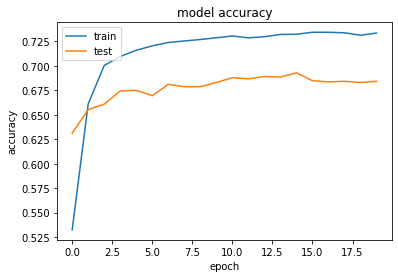

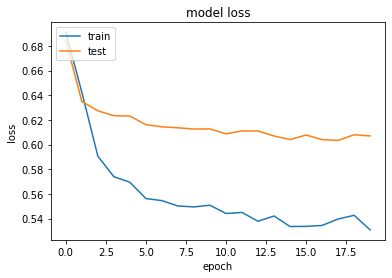

In [12]:
#collapse_hide
accuracy = results.history['win_output_accuracy']
val_accuracy = results.history['val_win_output_accuracy']
loss = results.history['win_output_loss']
val_loss = results.history['val_win_output_loss']
# summarize history for accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Pearson coefficient:  0.46


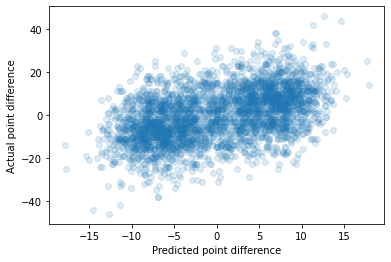

In [13]:
#collapse_hide
def transform_y(preds,stats_cache):
    preds = stats_cache['var'][1] * preds + stats_cache['mean'][1]
    return preds

preds = mymodel.predict(X_test)

tmp=0

x = transform_y(preds[1],stats_cache_train).reshape(-1)
y = transform_y(Y_norm_test[1],stats_cache_train).reshape(-1)


print('Pearson coefficient: ', round(stats.pearsonr(x, y)[0]*100)/100)
plt.scatter(x, y, alpha=0.15)
# plt.title('Scatter plot pythonspot.com')
plt.xlabel('Predicted point difference')
plt.ylabel('Actual point difference')
plt.show()

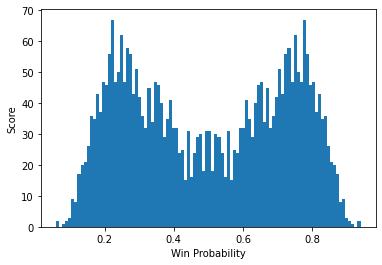

In [14]:
#collapse_hide
x = preds[0].reshape(-1)

plt.hist(x,bins=100)
# plt.title('Scatter plot pythonspot.com')
plt.xlabel('Predicted Win Probability')
plt.ylabel('Score')
plt.show()

In [15]:
#collapse_hide
embeddings = mymodel.layers[3].get_weights()[0]

t = TSNE(n_components=2)
embed_tsne = t.fit_transform(embeddings)

In [16]:
#collapse_hide
df_regSeason_full['T1_TeamName'] = df_regSeason_full['T1_TeamID'].apply(lambda x: teams_dict[x]) + '-' + df_regSeason_full['Season'].astype(str)
df_agg=df_regSeason_full.groupby('T1_TeamName').mean()
df_agg.reset_index(inplace=True,drop=False)
df_agg['Score_diff'] = -df_agg['Score_diff'] 
df_agg['Win'] = -df_agg['Win']
df_agg[['T1_TeamName','Win','Score_diff']]
df_agg.drop(columns='Season',inplace=True)

df_tourney_data = pd.read_csv(dataLoc/'MNCAATourneyCompactResults.csv')
df_tourney_data['WTeamName'] = df_tourney_data['WTeamID'].apply(lambda x: teams_dict[x]) + '-' + df_tourney_data['Season'].astype(str)
df_tourney_data['Wins'] = 0
df_wins = df_tourney_data[['WTeamName','Wins']].groupby('WTeamName').count()
tourneyWinners = [df_tourney_data.loc[df_tourney_data['Season']==s,'WTeamName'].values[-1] for s in df_tourney_data['Season'].unique()]

df_seeds = pd.read_csv(dataLoc/'MNCAATourneySeeds.csv')
df_seeds['TeamName'] = df_seeds['TeamID'].apply(lambda x: teams_dict[x]) + '-' + df_seeds['Season'].astype(str)
df_seeds['Seed'] = df_seeds['Seed'].str.extract(r'(\d+)')
df_seeds['WonTourney'] = df_seeds['TeamName'].apply(lambda x: True if x in tourneyWinners else False)
df_seeds = df_seeds[['TeamName','Seed','WonTourney']]

df_upsets = pd.read_csv('./data/2020-05-02-NCAA-Embeddings/Upsets.csv')
df_upsets['David']=df_upsets['David']+'-'+df_upsets['Season'].astype(str)
df_upsets['Goliath']=df_upsets['Goliath']+'-'+df_upsets['Season'].astype(str)
upsets = {}
for ii in df_upsets['David'].unique():
    upsets[ii] = 'Surprise'
for ii in df_upsets['Goliath'].unique():
    upsets[ii] = 'Bust'
df_seeds = pd.merge(left=df_seeds, right=df_wins, how='left', left_on='TeamName',right_index=True)
df_seeds['Wins'].fillna(0,inplace=True)

def upset(x):
    try:
        y = upsets[x]
    except:
        y = None
    return y
df_seeds['Upset'] = df_seeds['TeamName'].apply(lambda x: upset(x))

df = pd.DataFrame(embed_tsne,columns=['factor1','factor2'])
df['TeamName'] = [str(teams_dict[int(oh_to_id[x][-4:])]) + '-' + oh_to_id[x][:4] for x in df.index]
df['Season'] = [int(oh_to_id[x][:4])for x in df.index]

df = pd.merge(left=df, right=df_seeds, how='left', on='TeamName')
df = pd.merge(left=df, right=df_agg, how='left', left_on='TeamName',right_on='T1_TeamName')

df = df[['TeamName','Season','factor1','factor2','Win','Score_diff','Seed','Wins','Upset','WonTourney']]
df.columns = ['TeamName','Season','factor1','factor2','RegWins','RegPoint_diff','Seed','TourneyWins','Upset','WonTourney']

df2020 = df[df['Season']==2020].copy()

df.dropna(inplace=True,subset=['Seed'])

df['TourneyWinsScaled'] = df['TourneyWins']/df['TourneyWins'].max()
df['SeedScaled'] = df['Seed'].astype(int)/df['Seed'].astype(int).max()

df.head()

TeamName  Season    factor1    factor2   RegWins  \
2          Alabama-1985    1985 -40.301720 -41.133968 -0.700000   
8          Arizona-1985    1985 -37.231388 -26.685387 -0.666667   
11        Arkansas-1985    1985 -39.990566 -22.265013 -0.636364   
14          Auburn-1985    1985 -37.381886 -37.182011 -0.620690   
21  Boston College-1985    1985 -34.809566 -44.936821 -0.615385   

    RegPoint_diff Seed  TourneyWins Upset WonTourney  TourneyWinsScaled  \
2       -7.800000   07          2.0  None      False           0.333333   
8       -7.185185   10          0.0  None      False           0.000000   
11      -3.636364   09          1.0  None      False           0.166667   
14      -3.689655   11          2.0  None      False           0.333333   
21      -5.269231   11          2.0  None      False           0.333333   

    SeedScaled  
2       0.4375  
8       0.6250  
11      0.5625  
14      0.6875  
21      0.6875

In [17]:
#collapse_hide
selector = alt.selection_single(empty='all', fields=['TeamName'])

base = alt.Chart(df).mark_point(filled=True,size=50).encode(
    color=alt.condition(selector,
                        alt.Color('WonTourney:N', scale=alt.Scale(scheme='tableau10')),
                        alt.value('lightgray') ),
    order=alt.Order('WonTourney:N', sort='ascending'),
    tooltip=['TeamName','Seed']
).properties(
    width=500,
    height=500
).add_selection(selector).interactive()

base.encode( alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-75,50])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-32,11])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1.05,-.3])) )

alt.HConcatChart(...)

In [18]:
#collapse_hide
selector = alt.selection_single(empty='all', fields=['TeamName'])

base = alt.Chart(df).mark_point(filled=True,size=35).encode(
    color=alt.condition(selector,
                        alt.Color('TourneyWins:Q', scale=alt.Scale(scheme='viridis',reverse=False)),
                        alt.value('lightgray') ),
    order=alt.Order('TourneyWins:Q', sort='ascending'),
    tooltip=['TeamName','Seed']
).properties(
    width=500,
    height=500
).add_selection(selector).interactive()

base.encode( alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-75,50])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-32,11])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1.05,-.3])) )

alt.HConcatChart(...)

In [19]:
#collapse_hide
selector = alt.selection_single(empty='all', fields=['TeamName'])

base = alt.Chart(df).mark_point(filled=True,size=35).encode(
    color=alt.condition(selector,
                        alt.Color('Seed:Q', scale=alt.Scale(scheme='viridis',reverse=True)),
                        alt.value('lightgray') ),
    order=alt.Order('Seed:Q', sort='descending'),
    tooltip=['TeamName','Seed']
).properties(
    width=500,
    height=500
).add_selection(selector).interactive()

base.encode( alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-75,50])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-32,11])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1.05,-.3])) )

alt.HConcatChart(...)

In [20]:
#collapse_hide
selector = alt.selection_single(empty='all', fields=['TeamName'])

base = alt.Chart(df).mark_point(filled=True,size=50).encode(
    color=alt.condition(selector,
                        alt.Color('Upset:N', scale=alt.Scale(scheme='tableau10')),
                        alt.value('lightgray') ),
    order=alt.Order('Upset:N', sort='ascending'),
    tooltip=['TeamName','Seed']
).properties(
    width=500,
    height=500
).add_selection(selector).interactive()

base.encode( alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-75,50])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-32,11])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1.05,-.3])) )

alt.HConcatChart(...)

In [21]:
#collapse_hide
select_year = alt.selection_single(
    name='select', fields=['Season'], init={'Season': 2019},
    bind=alt.binding_range(min=1985, max=2019, step=1))

selector = alt.selection_single(empty='all', fields=['TeamName'])

##
base = alt.Chart(df).mark_point(filled=True,size=50).encode(
    color=alt.condition(selector,
                        alt.Color('TourneyWins:Q', scale=alt.Scale(scheme='viridis',reverse=False)),
                        alt.value('lightgray') ),
    order=alt.Order('Seed:Q', sort='descending'),
    tooltip=['TeamName','Seed']
).properties(
    width=500,
    height=500
).add_selection(select_year).transform_filter(select_year).add_selection(selector).interactive()

base.encode( alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-75,50])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-32,11])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1.05,-.3])) )

alt.HConcatChart(...)

In [22]:
#collapse_hide
## 2020 plot
selector = alt.selection_single(empty='all', fields=['TeamName'])

base = alt.Chart(df2020).mark_point(filled=True,size=50).encode(
    color=alt.condition(selector,
                        alt.Color('TeamName:N'),
                        alt.value('lightgray') ),
    order=alt.Order('RegWins:Q', sort='ascending'),
    tooltip=['TeamName']
).properties(
    width=500,
    height=500
).add_selection(selector).interactive()

base.encode( alt.X('factor1:Q', scale=alt.Scale(domain=[-70,60])), alt.Y('factor2:Q', scale=alt.Scale(domain=[-65,75])) )  | base.encode( alt.X('RegPoint_diff:Q', scale=alt.Scale(domain=[-21,26])),alt.Y('RegWins:Q',scale=alt.Scale(domain=[-1,0])) )

alt.HConcatChart(...)